### 1. Data Import and Library Initialization
This block loads necessary Python libraries, sets computation threads, and prepares for image processing and machine learning tasks. GPU support is also configured for PyTorch compatibility.

In [1]:
#!pip install randomsplit

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
torch.set_num_threads(2) # this makes it run better on elab
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# this allows pytorch to use a GPU, if one is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Load Dataset from Local or Remote Source
Loads the .npz dataset file containing training and testing images and their labels.

In [3]:
import os
import os.path
#data = np.load(os.path.expanduser('~') + '/Desktop/Machine Learning/assignment 2/Assignment2Data.npz')

In [4]:
data = np.load('./Assignment2Data.npz')

In [5]:
data.files

['train_images', 'train_labels', 'test_images', 'test_labels']

### 3. Unpack Dataset into Training and Testing Arrays
Separates the data into train_images, train_labels, test_images, and test_labels. This sets the base for all future modeling. labelled data


In [6]:
train_data = data['train_images']
train_labels = data['train_labels']
test_data = data['test_images']
test_labels = data['test_labels']

In [7]:
label_dict = {
            0: "adipose",
            1: "lymphocytes",
            2: "normal colon mucosa",
            3: "cancer-associated stroma",
            4: "colorectal adenocarcinoma epithelium"
        }

**View an example image and its label**
note that each image is of size 28x28x3. The 28 corresponds to the height and width of the image in pixels. There are 3 channels, corresponding to the amount of Red, Green, and Blue in each pixel.

In [8]:
label1 = train_labels[0]
label_dict[label1[0]]

'adipose'

Text(0.5, 0.01, 'adipose')

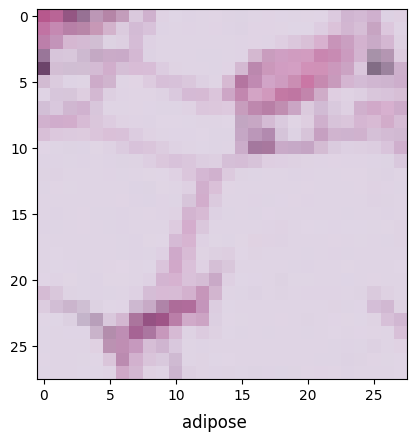

In [9]:
image1 = train_data[0,:,:,:]
plt.imshow(image1)
plt.figtext(0.5, 0.01, label_dict[label1[0]], wrap=True, horizontalalignment='center', fontsize=12)

**Here We are looking at each channel individually by plotting one of the layers.**

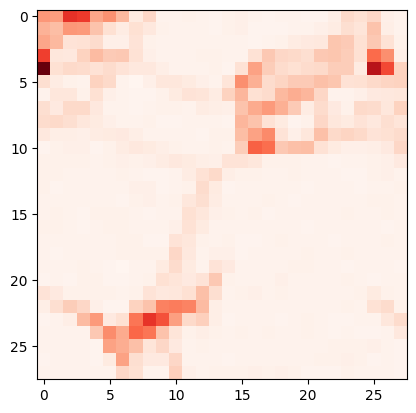

In [10]:
plt.imshow(train_data[0,:,:,0],cmap='Reds_r')

### 4. Prepare Data for PyTorch
To train a model using Pytorch, we need to convert our data into tensors. We can think of tensor as a multidimensional array. We use tensors, rather than an np.array, as the data type is optimised for GPUs.

Normalizes pixel values, reshapes data into channel-first format, and creates PyTorch-compatible arrays. Essential for using CNNs with GPU acceleration.


In [14]:
#split into test and train
X_train, y_train = data['train_images'], data['train_labels'].reshape(-1)
X_test, y_test = data['test_images'], data['test_labels'].reshape(-1)

X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_train = X_train.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

### 5. Custom Dataset Class and Data Augmentation
Defines a PyTorch Dataset wrapper and applies transformations like flipping and rotation. Also prepares training, validation, and test loaders.

In [15]:

class PathMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)

augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10)
])

train_full = PathMNISTDataset(X_train, y_train, transform=None)
val_size = int(0.1 * len(train_full))
train_size = len(train_full) - val_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])
test_dataset = PathMNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


### 6. CNN Model Architecture Definition
Implements a two-layer convolutional neural network with ReLU, max pooling, dropout, and fully connected layers. Designed for 28x28 RGB input.

In [16]:

import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2) # Output: (16, 14, 14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2) # Output: (32, 7, 7)
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.conv1(x.float())
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        output = self.out(x)
        return output, x


### 7. CNN Training Loop with Early Stopping
Defines the training process with accuracy tracking, early stopping, and model checkpointing to prevent overfitting.

In [17]:
def train(num_epochs, cnn, loaders, optimizer, loss_func, device, patience=3):
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        cnn.train()
        correct = total = 0

        for images, labels in loaders['train']:
            images, labels = images.to(device), labels.to(device)

            outputs, _ = cnn(images)
            loss = loss_func(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_acc_list.append(train_acc)

        # Validation
        cnn.eval()
        correct = total = 0
        with torch.no_grad():
            for images, labels in loaders['val']:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = cnn(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        val_acc_list.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

        # Early Stopping Logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = cnn.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if best_model_state:
        cnn.load_state_dict(best_model_state)

    return cnn, train_acc_list, val_acc_list


### 8. Run CNN Experiments with Hyperparameter Variations
Executes multiple experiments using different configurations (optimizers, learning rates). Logs accuracy over epochs for both training and validation sets.

In [18]:

def run_experiment(config, loaders, device):
    # Initialize the CNN model with parameters from the config
    model = CNN(num_classes=config['num_classes'], dropout_rate=config['dropout']).to(device)

    # Choose the optimizer based on the 'optimizer' key in the config
    if config['optimizer'] == 'Adam':
        # Adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        # Stochastic Gradient Descent (SGD) optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], momentum=config.get('momentum', 0)) # Added momentum

    # Define the loss function (Cross-Entropy Loss for classification)
    loss_func = nn.CrossEntropyLoss()

    # Train the model using the specified configuration and optimizer
    model, train_curve, val_curve = train(
        num_epochs=config['epochs'],
        cnn=model,
        loaders=loaders,
        optimizer=optimizer,
        loss_func=loss_func,
        device=device,
        patience=config.get('patience', 3)
    )

    # Evaluate the trained model on the test set
    model.eval()  # Set the model to evaluation mode
    correct = total = 0
    # Disable gradient calculation for evaluation
    with torch.no_grad():
        # Iterate through the test data loader
        for images, labels in loaders['test']:
            # Move data to the specified device
            images, labels = images.to(device), labels.to(device)
            # Get model predictions
            outputs, _ = model(images)
            # Get the predicted class (index with the highest probability)
            _, predicted = torch.max(outputs, 1)
            # Count correct predictions
            correct += (predicted == labels).sum().item()
            # Count total samples
            total += labels.size(0)
    # Calculate test accuracy
    test_acc = correct / total

    # Store the results of the experiment
    result = {
        'config': config,           # The configuration used for this experiment
        'train_curve': train_curve, # Training accuracy history per epoch
        'val_curve': val_curve,     # Validation accuracy history per epoch
        'test_acc': test_acc,       # Final test accuracy
        'model_state_dict': model.state_dict() # State dictionary of the trained model
    }
    # Return the results
    return result

### 9. Determine and Reload the Best Performing Model
Subtext: Identifies and reloads the model with the highest test accuracy across all experiments for final evaluation.

In [19]:
results = []

configs = [
    # Adam optimizer with 10 epochs
    {'num_classes': 9, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-4, 'epochs': 10, 'patience': 3, 'optimizer': 'Adam'}, # Added 'optimizer': 'Adam'
    {'num_classes': 9, 'dropout': 0.5, 'lr': 0.0005, 'weight_decay': 1e-4, 'epochs': 10, 'patience': 3, 'optimizer': 'Adam'}, # Added 'optimizer': 'Adam'

    # SGD optimizer with 10 epochs
    {'num_classes': 9, 'dropout': 0.5, 'lr': 0.01, 'weight_decay': 1e-4, 'epochs': 10, 'patience': 3, 'optimizer': 'SGD', 'momentum': 0.9},
    {'num_classes': 9, 'dropout': 0.5, 'lr': 0.005, 'weight_decay': 1e-4, 'epochs': 10, 'patience': 3, 'optimizer': 'SGD', 'momentum': 0.9},
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, config in enumerate(configs):
    # Continue numbering experiments from where the previous cell left off
    experiment_number = len(results) + 1
    print(f"\nRunning Experiment {experiment_number} with config: {config}")
    result = run_experiment(config, loaders, device)
    results.append(result)

print(f"\nFinished running {len(results)} experiments.")


Running Experiment 1 with config: {'num_classes': 9, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 10, 'patience': 3, 'optimizer': 'Adam'}
Epoch [1/10]  Train Acc: 0.6431  Val Acc: 0.7567
Epoch [2/10]  Train Acc: 0.7779  Val Acc: 0.7738
Epoch [3/10]  Train Acc: 0.8042  Val Acc: 0.8333
Epoch [4/10]  Train Acc: 0.8207  Val Acc: 0.8418
Epoch [5/10]  Train Acc: 0.8376  Val Acc: 0.8331
Epoch [6/10]  Train Acc: 0.8453  Val Acc: 0.8888
Epoch [7/10]  Train Acc: 0.8517  Val Acc: 0.8668
Epoch [8/10]  Train Acc: 0.8627  Val Acc: 0.8609
Epoch [9/10]  Train Acc: 0.8723  Val Acc: 0.8937
Epoch [10/10]  Train Acc: 0.8804  Val Acc: 0.8901

Running Experiment 2 with config: {'num_classes': 9, 'dropout': 0.5, 'lr': 0.0005, 'weight_decay': 0.0001, 'epochs': 10, 'patience': 3, 'optimizer': 'Adam'}
Epoch [1/10]  Train Acc: 0.6148  Val Acc: 0.7544
Epoch [2/10]  Train Acc: 0.7539  Val Acc: 0.8079
Epoch [3/10]  Train Acc: 0.7939  Val Acc: 0.8326
Epoch [4/10]  Train Acc: 0.8134  Val Acc: 0.841

### 10. Determine and Reload the Best Performing Model
Identifies and reloads the model with the highest test accuracy across all experiments for final evaluation.

In [20]:
best_result = max(results, key=lambda x: x['test_acc'])

best_model = CNN(
    num_classes=best_result['config']['num_classes'],
    dropout_rate=best_result['config']['dropout']
).to(device)

best_model.load_state_dict(best_result['model_state_dict'])

print("\nBest Model Configuration:")
for k, v in best_result['config'].items():
    print(f"{k}: {v}")
print(f"Test Accuracy: {best_result['test_acc']:.4f}")



Best Model Configuration:
num_classes: 9
dropout: 0.5
lr: 0.001
weight_decay: 0.0001
epochs: 10
patience: 3
optimizer: Adam
Test Accuracy: 0.8617


### 11. Training and Validation Accuracy Plots
Visualizes training and validation accuracy curves per optimizer and learning rate setting. Helps analyze model convergence and performance differences.

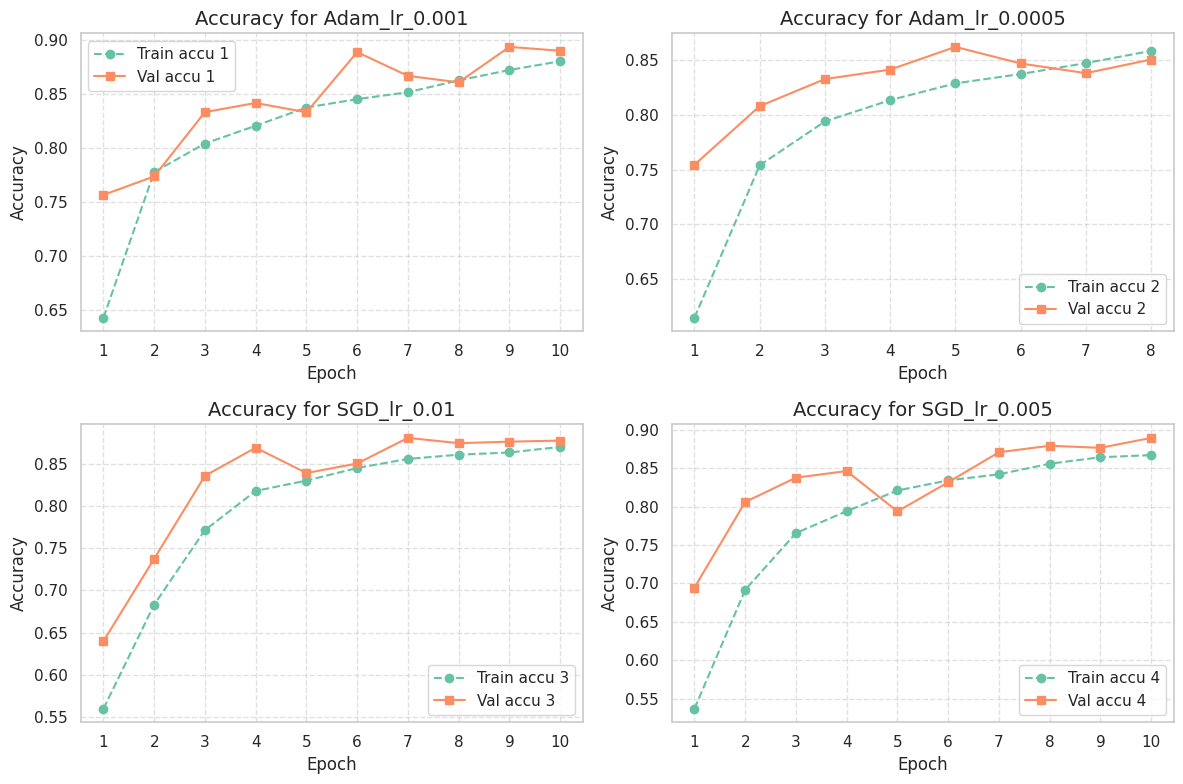

In [21]:

import math # Import math to calculate grid size

sns.set(style="whitegrid")
sns.set_palette("Set2")

# Group results by optimizer and learning rate
grouped_results = {}
for result in results:
    config = result['config']
    optimizer = config.get('optimizer', 'Adam') # Default to Adam if not specified
    lr = config['lr']
    key = f"{optimizer}_lr_{lr}"
    if key not in grouped_results:
        grouped_results[key] = []
    grouped_results[key].append(result)

# Calculate the number of rows and columns for the subplots
num_plots = len(grouped_results)
n_cols = 2 # You can adjust the number of columns if needed
n_rows = math.ceil(num_plots / n_cols)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
# Flatten the axes array if it's multi-dimensional
if n_rows > 1 or n_cols > 1:
    axes = axes.flatten()
else:
    axes = [axes] # Ensure axes is iterable even for a single plot

# Plot training and validation accuracy for each group
for i, (key, experiment_list) in enumerate(grouped_results.items()):
    ax = axes[i]
    for j, result in enumerate(experiment_list):
        epochs = list(range(1, len(result['train_curve']) + 1))
        ax.plot(epochs, result['train_curve'], marker='o', linestyle='--', label=f"Train accu {i*len(experiment_list) + j + 1}")
        ax.plot(epochs, result['val_curve'], marker='s', linestyle='-', label=f"Val accu {i*len(experiment_list) + j + 1}")

    ax.set_title(f"Accuracy for {key}", fontsize=14)
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_xticks(epochs) # Set x-ticks based on the epochs of the last experiment in the group
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 12. Final Evaluation with Classification Report and Confusion Matrix
Calculates precision, recall, F1 score, and normalized confusion matrix for the best CNN model on test data. Displays results with a heatmap.

Classification Report:

                                      precision    recall  f1-score   support

                             adipose       0.98      0.99      0.98      1338
                         lymphocytes       0.98      0.66      0.79       634
                 normal colon mucosa       0.62      0.94      0.74       741
            cancer-associated stroma       0.86      0.84      0.85       421
colorectal adenocarcinoma epithelium       0.92      0.79      0.85      1233

                            accuracy                           0.86      4367
                           macro avg       0.87      0.84      0.84      4367
                        weighted avg       0.89      0.86      0.86      4367


Normalized Confusion Matrix (%):

[[9.903e+01 0.000e+00 9.000e-01 0.000e+00 7.000e-02]
 [1.740e+00 6.562e+01 3.076e+01 4.700e-01 1.420e+00]
 [1.750e+00 2.700e-01 9.352e+01 5.400e-01 3.910e+00]
 [0.000e+00 7.100e-01 5.230e+00 8.432e+01 9.740e+00]
 [4.100e-01 2.400e-01 1.

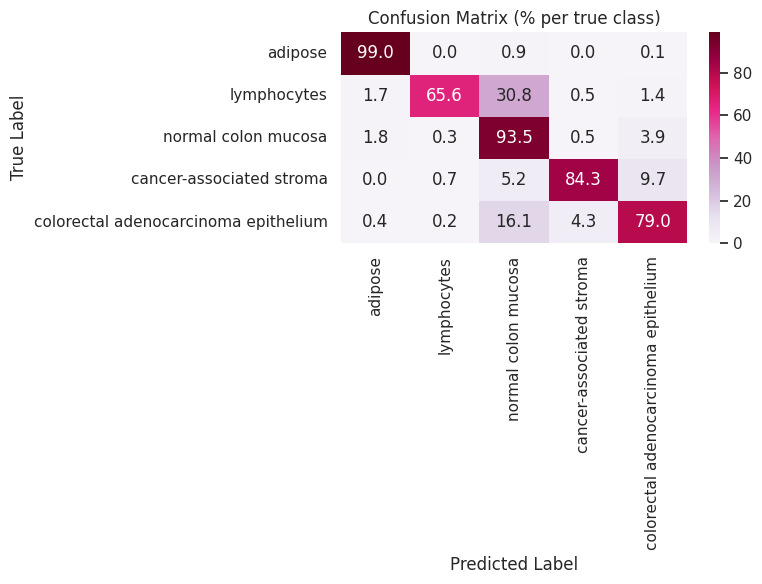

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Accumulate predictions and true labels
all_preds = []
all_labels = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)                     # Move to device
        labels = labels.to(device)                     # Needed for .cpu() later
        outputs, _ = best_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())      # Store predictions
        all_labels.extend(labels.cpu().numpy())        # Store true labels

# --------------------------
# Display classification report
# --------------------------
# Ensure label_dict maps correctly (e.g., {0: "class0", 1: "class1", ...})
target_names = list(label_dict.values())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))

# --------------------------
# Confusion Matrix (Normalized)
# --------------------------
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

print("\nNormalized Confusion Matrix (%):\n")
print(np.round(cm_normalized, 2))

# --------------------------
# Plot Heatmap
# --------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".1f", cmap='PuRd',  #BuPu/YlGnBu
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (% per true class)")
plt.tight_layout()
plt.show()


### 13. Baseline Model: Logistic Regression
Trains a baseline multinomial logistic regression model using flattened grayscale features for comparison with CNN performance.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Classification Report:
                                      precision    recall  f1-score   support

                             adipose       0.15      0.03      0.05      1338
                         lymphocytes       0.19      0.23      0.21       634
                 normal colon mucosa       0.28      0.05      0.08       741
            cancer-associated stroma       0.12      0.07      0.09       421
colorectal adenocarcinoma epithelium       0.27      0.64      0.38      1233

                            accuracy                           0.24      4367
                           macro avg       0.20      0.20      0.16      4367
                        weighted avg       0.21      0.24      0.17      4367



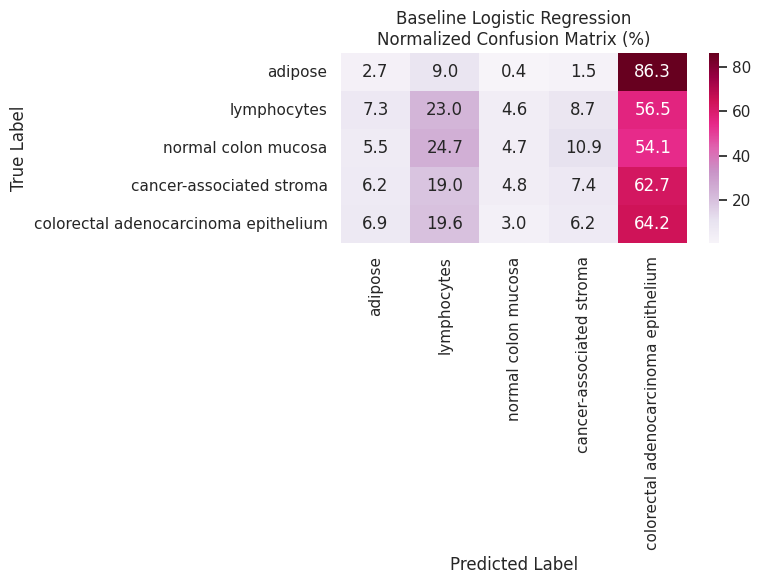


--- Accuracy Comparison ---
Logistic Regression Test Accuracy: 0.2381
Best CNN Model Test Accuracy:       0.8617


In [23]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# STEP 1: Convert RGB to summed grayscale and flatten to 1D
train_1d = np.empty((len(train_data), 28 * 28))
for i in range(len(train_data)):
    train_1d[i, :] = np.reshape(
        train_data[i, :, :, 0] + train_data[i, :, :, 1] + train_data[i, :, :, 2], -1
    )

test_1d = np.empty((len(test_data), 28 * 28))
for i in range(len(test_data)):
    test_1d[i, :] = np.reshape(
        test_data[i, :, :, 0] + test_data[i, :, :, 1] + test_data[i, :, :, 2], -1
    )

# STEP 2: Prepare labels
y_train = train_labels.ravel()
y_test = test_labels.ravel()

# STEP 3: Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial', n_jobs=-1)
log_reg.fit(train_1d, y_train)

# STEP 4: Predict on test data
test_preds = log_reg.predict(test_1d)
test_acc_lr = accuracy_score(y_test, test_preds)

# STEP 5: Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, test_preds, target_names=list(label_dict.values())))

# STEP 6: Confusion Matrix (Normalized)
cm_lr = confusion_matrix(y_test, test_preds)
cm_norm = cm_lr.astype("float") / cm_lr.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap='PuRd',
            xticklabels=list(label_dict.values()),
            yticklabels=list(label_dict.values()))
plt.title("Baseline Logistic Regression\nNormalized Confusion Matrix (%)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# STEP 7: Compare with CNN model
cnn_acc = best_result['test_acc']
print("\n--- Accuracy Comparison ---")
print(f"Logistic Regression Test Accuracy: {test_acc_lr:.4f}")
print(f"Best CNN Model Test Accuracy:       {cnn_acc:.4f}")


### 14. Comparison: Logistic Regression vs CNN
Visual comparison of test accuracy for logistic regression and CNN using a bar plot. Highlights superiority of deep learning for image classification.

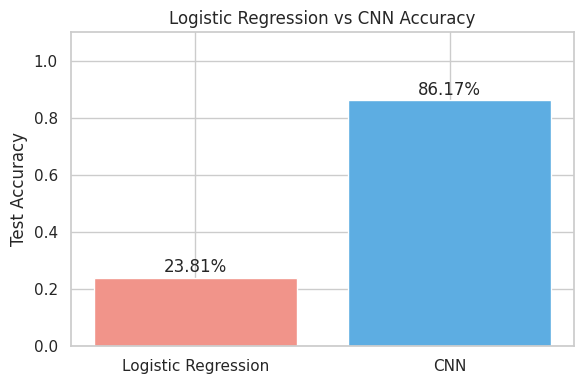

In [24]:
#Bar Chart comparing accuracies of CNN and logreg
plt.figure(figsize=(6, 4))
bars = plt.bar(['Logistic Regression', 'CNN'], [test_acc_lr, cnn_acc],
               color=['#F1948A', '#5DADE2'])
for i, acc in enumerate([test_acc_lr, cnn_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12)
plt.ylim(0, 1.1)
plt.ylabel("Test Accuracy")
plt.title("Logistic Regression vs CNN Accuracy")
plt.tight_layout()
plt.show()